# Predicting NFL Scores

Jacob Shor, Arnav Shivansh, Oisín Clark

## Introduction

It is no question that sports are a central part of modern American society. With people coast to coast invested in their teams, no sport gets a larger American audience than American Football. According to a [Gallup poll](https://news.gallup.com/poll/4735/sports.aspx), around 37% of people say that football is their favorite sport, blowing the next most popular sport, basketball, out of the water with only 11%. 
    
Of course, where there’s people, there’s gambling. According to [A Football Report](https://afootballreport.com/blog/how-much-money-is-being-bet-on-sports-every-year), around $100 billion dollars is spent on American football gambling alone. There is clearly a large market for projecting the scores of games and something that statisticians have been working on for a long time. The problem is that many of these websites that set out to predict outcomes of games use anecdotal evidence and personal “expertise” to arrive at their conclusions. Even the websites that try to use more data science-driven methods such as FantasyPro tend to do so in a way that is based on these professional predictors as seen [here](https://support.fantasypros.com/hc/en-us/articles/115002206187-In-a-nutshell-how-do-you-measure-an-expert-s-accuracy-). 

In this tutorial, we will take you through the steps to look at how we can use simple elements such as yards and turnovers to predict final scores of teams. We will start with a null hypothesis that there is no correlation between yards and points and turnovers and points and then see if we can find a correlation. Due to large amounts of variability in matches due to other factors, some as simple as the basic skill of each team, it is impossible to have perfect predictions. However, even a slight advantage is incredibly significant in this realm and a data science-driven approach is a perfect way to see trends human eyes miss.


### Background

Throughout this project, we will be using many common methods and libraries. Since describing each one in great enough detail would be too cumbersome for this tutorial, they will not be included. However, links describing the methods and libraries will be embedded should you need extra explanation. Note that all work is programmed in [python](https://www.python.org).

In [1]:
import pandas as pd
import numpy as np
import requests 
!pip install requests
from bs4 import BeautifulSoup
import statsmodels.api as sm
from statsmodels.graphics.regressionplots import plot_partregress_grid
import statsmodels
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
!conda install -y lxml

Solving environment: done


==> WARNING: A newer version of conda exists. <==
  current version: 4.9.0
  latest version: 4.9.2

Please update conda by running

    $ conda update -n base conda



# All requested packages already installed.



## Data Collection

The data collected was from [Pro Football Reference](https://www.pro-football-reference.com), a website that collects all sorts of data for variance sports but, as its name suggests, started with football. The data was collected using [web scraping](https://en.wikipedia.org/wiki/Web_scraping). Each page from 1985 through 2019 was [requested](https://requests.readthedocs.io/en/master/) and fed through [Beautiful Soup](https://pypi.org/project/beautifulsoup4/) for parsing. Throughout this project, [pandas](https://pandas.pydata.org) dataframes will be used to store the data.

Pro Football Reference has data on over 9,500 games from the 1985 season up until now and is still actively updating. This particular table provides the following information for each game:
- Week
- Day of week
- Date
- Time
- Winner
- Loser
- Who’s home
- Winners and Losers:
  - Points
  - Yards
  - Turnovers

However, not all of this data can be easily read from the pandas dataframe as it is still very messy. The raw results of the web scraping can be seen below.

In [2]:
r = requests.get("https://www.pro-football-reference.com/years/1985/games.htm")
root = BeautifulSoup(r.content,"html")
tables = root.find_all(r'table')
df1 = pd.read_html(str(tables[0]))
df1 = df1[0]
df1["year"] = 1985
scores = df1
for i in range(1986, 2020):
    r = requests.get("https://www.pro-football-reference.com/years/" + str(i) + "/games.htm")
    root = BeautifulSoup(r.content,"html")
    tables = root.find_all(r'table')
    df1 = pd.read_html(str(tables[0]))
    df1 = df1[0]
    df1["year"] = i
    scores = scores.append(df1, ignore_index=True)
    
scores

,Week,Day,Date,Time,Winner/tie,Unnamed: 5,Loser/tie,Unnamed: 7,PtsW,PtsL,YdsW,TOW,YdsL,TOL,year
0,1,Sun,September 8,1:00PM,New England Patriots,NaN,Green Bay Packers,boxscore,26,20,410,5,205,2,1985
1,1,Sun,September 8,1:00PM,Detroit Lions,@,Atlanta Falcons,boxscore,28,27,286,2,300,1,1985
2,1,Sun,September 8,1:00PM,Chicago Bears,NaN,Tampa Bay Buccaneers,boxscore,38,28,436,3,307,2,1985
3,1,Sun,September 8,1:00PM,Seattle Seahawks,@,Cincinnati Bengals,boxscore,28,24,297,0,344,1,1985
4,1,Sun,September 8,1:00PM,Houston Oilers,NaN,Miami Dolphins,boxscore,26,23,394,4,360,3,1985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9498,Division,Sun,January 12,3:05PM,Kansas City Chiefs,NaN,Houston Texans,boxscore,51,31,434,1,442,1,2019
9499,Division,Sun,January 12,6:40PM,Green Bay Packers,NaN,Seattle Seahawks,boxscore,28,23,344,0,375,0,2019
9500,ConfChamp,Sun,January 19,3:05PM,Kansas City Chiefs,NaN,Tennessee Titans,boxscore,35,24,404,0,295,0,2019
9501,ConfChamp,Sun,January 19,6:40PM,San Francisco 49ers,NaN,Green Bay Packers,boxscore,37,20,354,0,358,3,2019


## Data Processing

This table isn’t very usable at this point. For one, the data includes games from the postseason (items labeled by “WildCard”, “Division”, “ConfChamp”, and “SuperBowl” in the “Week” column). These games have a few major differences compared to regular-season games. The first is that all of these teams are typically better than the average team. Since only the top 12 teams make it into the playoffs from the 32 team league, the teams that play these games will be at a higher skill level. Plus, the teams that win games in the playoffs will get to play even more games. The best two teams who make it to the Super Bowl may end up playing four times the number of games as a bad team who goes out round one. This only exacerbates the problem. Additionally, the stakes in these games are much higher. Players are under a lot of pressure and may play more conservatively than a regular-season game. For all of these reasons, in an effort to keep things as uniform as possible, postseason games will be excluded.

Next, we have to handle the two unnamed columns, “Unnamed: 5” and “Unnamed: 7”. “Unnamed: 5” is either the “@” symbol or “NaN”. This represents if the winning team is away (with “@”) or home (with “NaN”). We will rename the column “home” to make our table a bit more readable. “Unnamed: 7” was a column on the website that linked to the boxscore. This now provides us with no useful information and so we can remove it.


In [3]:
scores = scores.loc[scores['Week'].isin(['1','2','3','4','5','6','7','8','9','10','11','12','13','14','15','16','17'])]
scores.columns = ['Week', 'Day', 'Date', 'Time', 'Winner', 'home', 'Loser', 'rmv', 'PtsW', 'PtsL', 'YdsW', 'TOW', 'YdsL', 'TOL', 'year']
scores = scores.drop(columns = ["rmv"])
scores = scores.reset_index(drop=True)
scores

,Week,Day,Date,Time,Winner,home,Loser,PtsW,PtsL,YdsW,TOW,YdsL,TOL,year
0,1,Sun,September 8,1:00PM,New England Patriots,NaN,Green Bay Packers,26,20,410,5,205,2,1985
1,1,Sun,September 8,1:00PM,Detroit Lions,@,Atlanta Falcons,28,27,286,2,300,1,1985
2,1,Sun,September 8,1:00PM,Chicago Bears,NaN,Tampa Bay Buccaneers,38,28,436,3,307,2,1985
3,1,Sun,September 8,1:00PM,Seattle Seahawks,@,Cincinnati Bengals,28,24,297,0,344,1,1985
4,1,Sun,September 8,1:00PM,Houston Oilers,NaN,Miami Dolphins,26,23,394,4,360,3,1985
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8519,17,Sun,December 29,4:25PM,Philadelphia Eagles,@,New York Giants,34,17,400,0,397,2,2019
8520,17,Sun,December 29,4:25PM,Dallas Cowboys,NaN,Washington Redskins,47,16,517,1,271,2,2019
8521,17,Sun,December 29,4:25PM,Baltimore Ravens,NaN,Pittsburgh Steelers,28,10,304,2,168,2,2019
8522,17,Sun,December 29,4:25PM,Los Angeles Rams,NaN,Arizona Cardinals,31,24,424,0,393,5,2019


Now since we eventually want to be working with this data in machine learning algorithms, we must ensure that our data is of the proper type.

In [4]:
scores.dtypes

Week      object
Day       object
Date      object
Time      object
Winner    object
home      object
Loser     object
PtsW      object
PtsL      object
YdsW      object
TOW       object
YdsL      object
TOL       object
year       int64
dtype: object

We need all of this information to be stored as integers to allow us to work with it so we must cast each column as such. Additionally, we can easily make columns for total points, total yards, and total turnovers to give us more data to explore with. These columns can easily be made by simply adding together the winner’s and loser’s statistic in that area.

In [5]:
scores['Location'] = np.where(scores['home'] == '@', scores["Loser"], scores["Winner"])
scores['Location'] = scores.Location.str.rsplit(' ',1).str[0]
scores['PtsW'] = scores['PtsW'].astype(int)
scores['PtsL'] = scores['PtsL'].astype(int)
scores['YdsW'] = scores['YdsW'].astype(int)
scores['TOW'] = scores['TOW'].astype(int)
scores['YdsL'] = scores['YdsL'].astype(int)
scores['TOL'] = scores['TOL'].astype(int)
scores['year'] = scores['year'].astype(int)
scores['PtsT'] = scores['PtsW'] + scores['PtsL']
scores['YdsT'] = scores['YdsW'] + scores['YdsL']
scores['TOT'] = scores['TOW'] + scores['TOL']
scores 

,Week,Day,Date,Time,Winner,home,Loser,PtsW,PtsL,YdsW,TOW,YdsL,TOL,year,Location,PtsT,YdsT,TOT
0,1,Sun,September 8,1:00PM,New England Patriots,NaN,Green Bay Packers,26,20,410,5,205,2,1985,New England,46,615,7
1,1,Sun,September 8,1:00PM,Detroit Lions,@,Atlanta Falcons,28,27,286,2,300,1,1985,Atlanta,55,586,3
2,1,Sun,September 8,1:00PM,Chicago Bears,NaN,Tampa Bay Buccaneers,38,28,436,3,307,2,1985,Chicago,66,743,5
3,1,Sun,September 8,1:00PM,Seattle Seahawks,@,Cincinnati Bengals,28,24,297,0,344,1,1985,Cincinnati,52,641,1
4,1,Sun,September 8,1:00PM,Houston Oilers,NaN,Miami Dolphins,26,23,394,4,360,3,1985,Houston,49,754,7
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8519,17,Sun,December 29,4:25PM,Philadelphia Eagles,@,New York Giants,34,17,400,0,397,2,2019,New York,51,797,2
8520,17,Sun,December 29,4:25PM,Dallas Cowboys,NaN,Washington Redskins,47,16,517,1,271,2,2019,Dallas,63,788,3
8521,17,Sun,December 29,4:25PM,Baltimore Ravens,NaN,Pittsburgh Steelers,28,10,304,2,168,2,2019,Baltimore,38,472,4
8522,17,Sun,December 29,4:25PM,Los Angeles Rams,NaN,Arizona Cardinals,31,24,424,0,393,5,2019,Los Angeles,55,817,5


In [6]:
scores.dtypes

Week        object
Day         object
Date        object
Time        object
Winner      object
home        object
Loser       object
PtsW         int64
PtsL         int64
YdsW         int64
TOW          int64
YdsL         int64
TOL          int64
year         int64
Location    object
PtsT         int64
YdsT         int64
TOT          int64
dtype: object

Much better!

## Exploratory Analysis & Data Visualization

With all of our data collected and cleaned up, let's use some graphs to help us visualize what’s going on with this data. 

Here's all of our scores:

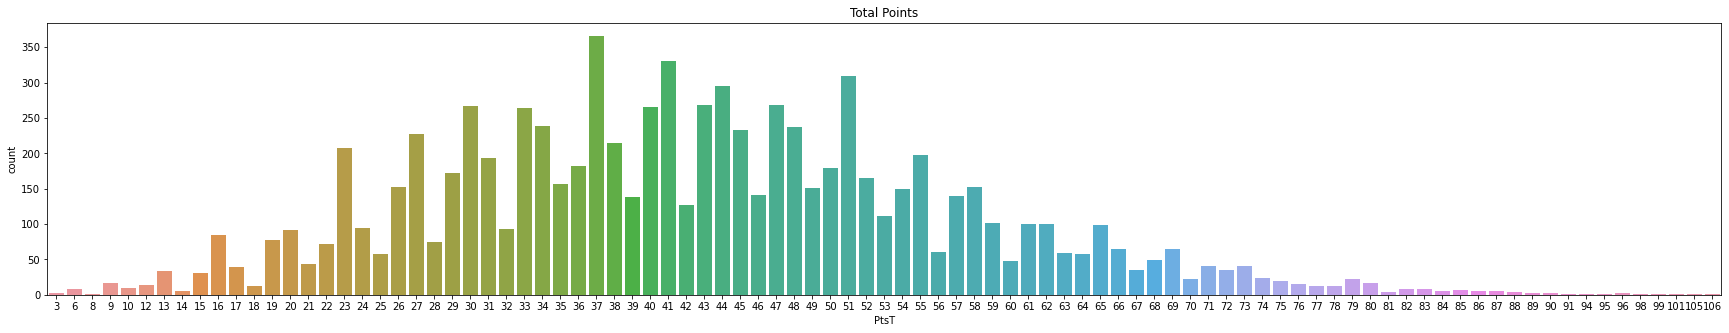

In [7]:
plt.figure(figsize = (30, 5))
score_bar = sns.countplot(x = 'PtsT', data = scores)
plt.title("Total Points");

Here's our yards:

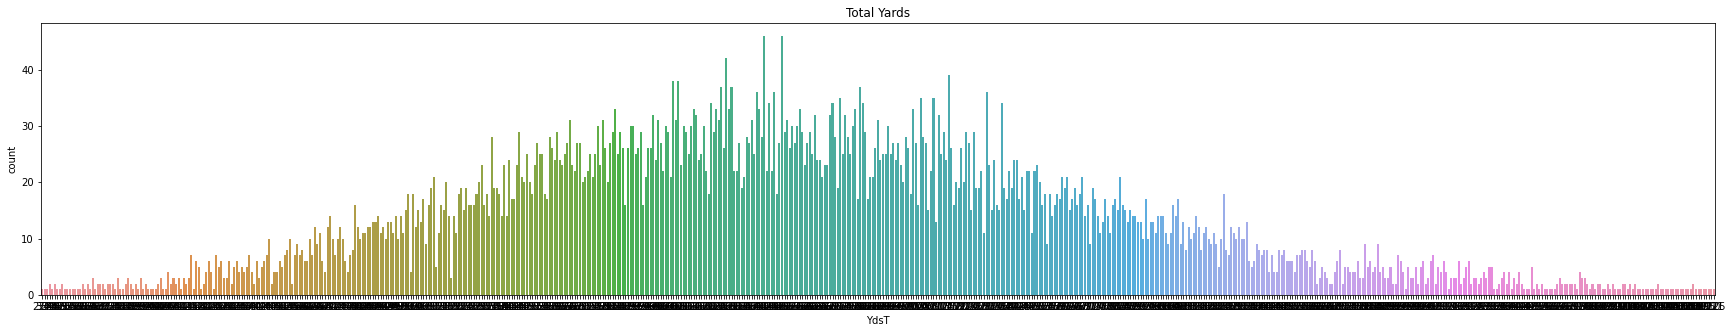

In [8]:
plt.figure(figsize = (30, 5))
yards_bar = sns.countplot(x = 'YdsT', data = scores)
plt.title("Total Yards");

And finally turnovers:

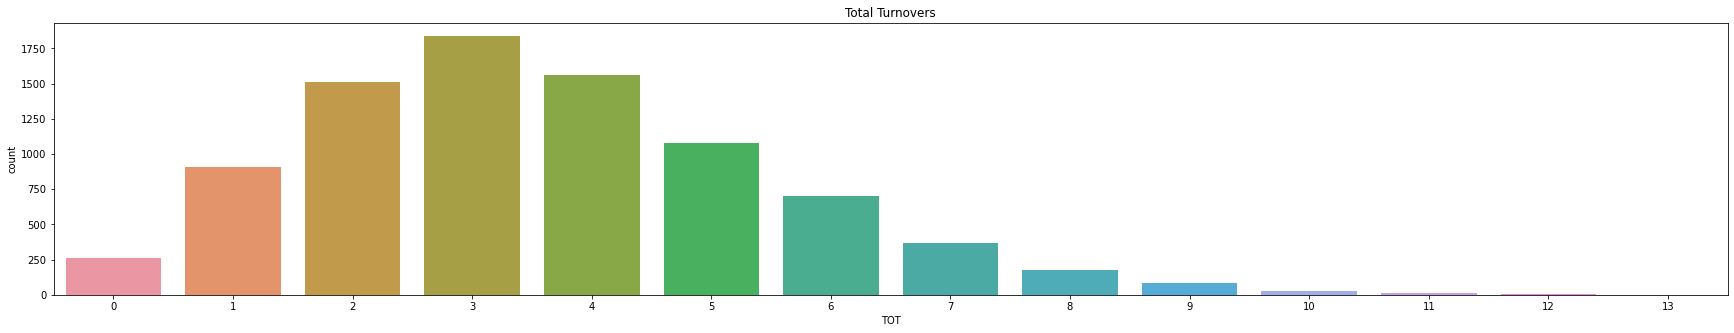

In [9]:
plt.figure(figsize = (30, 5))
yards_bar = sns.countplot(x = 'TOT', data = scores)
plt.title("Total Turnovers");

There are a few important things about these graphs to note. The most important thing is that these graphs are relatively normal. This is important because it allows us to make better predictions using this data. If it was bimodal or something else, it would have increased our average error. 

The other thing that should be noted is that the score chart has a few scores that are much less likely than the normal curve would suggest and some that are much less likely than would be normal. This problem can be exacerbated when only looking at a single team’s scores as opposed to their total:

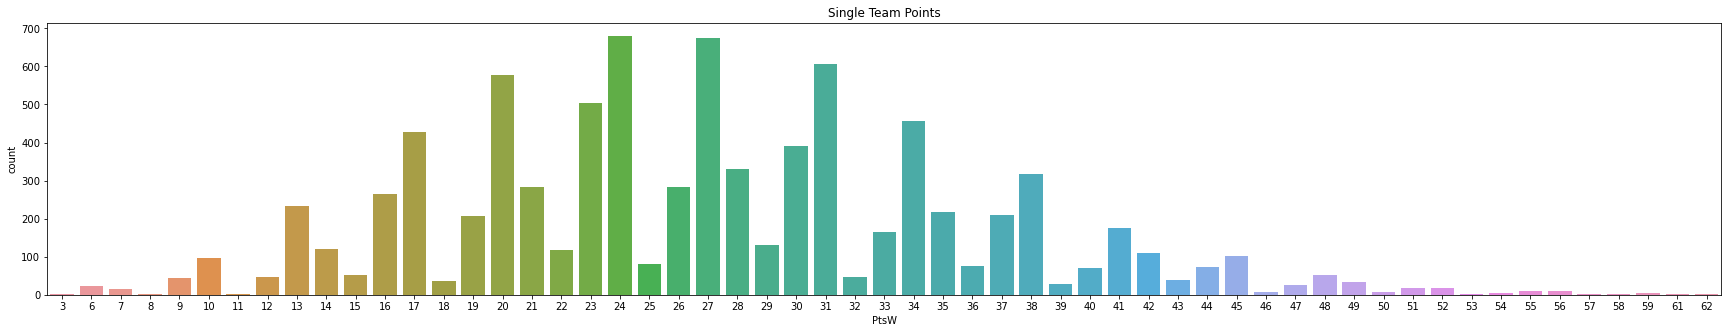

In [10]:
plt.figure(figsize = (30, 5))
score_bar = sns.countplot(x = 'PtsW', data = scores)
plt.title("Single Team Points");

Here we can still see an overall normal curve. However, there are some clear discrepancies. Take a look at the number of times a team scored 24 points vs how many times they scored 25 points. Even though they are right next to each other, a team is **much** more likely to score 24 points. This is because of the strange [scoring in football](https://en.wikipedia.org/wiki/American_football_rules). It is easy to get 24 points; most commonly done with three touchdowns (each worth 7 points) and a field goal (worth 3). These are the two most common ways of scoring. Contrast that to 25 which would require a touchdown and six field goals meaning that the team would need to score seven times using common scoring methods to get a score of 25. What this means is that our model will most likely end up with at least an error or two or three points as it might land in one of these “dead zones”. This is ok though as being able to get within a score or two is pretty good. It does mean that we should try to predict the total score as it is much more normal.

Finally, to get an idea if a correlation here even exists, let's take a look at yards vs score and turnovers vs score.

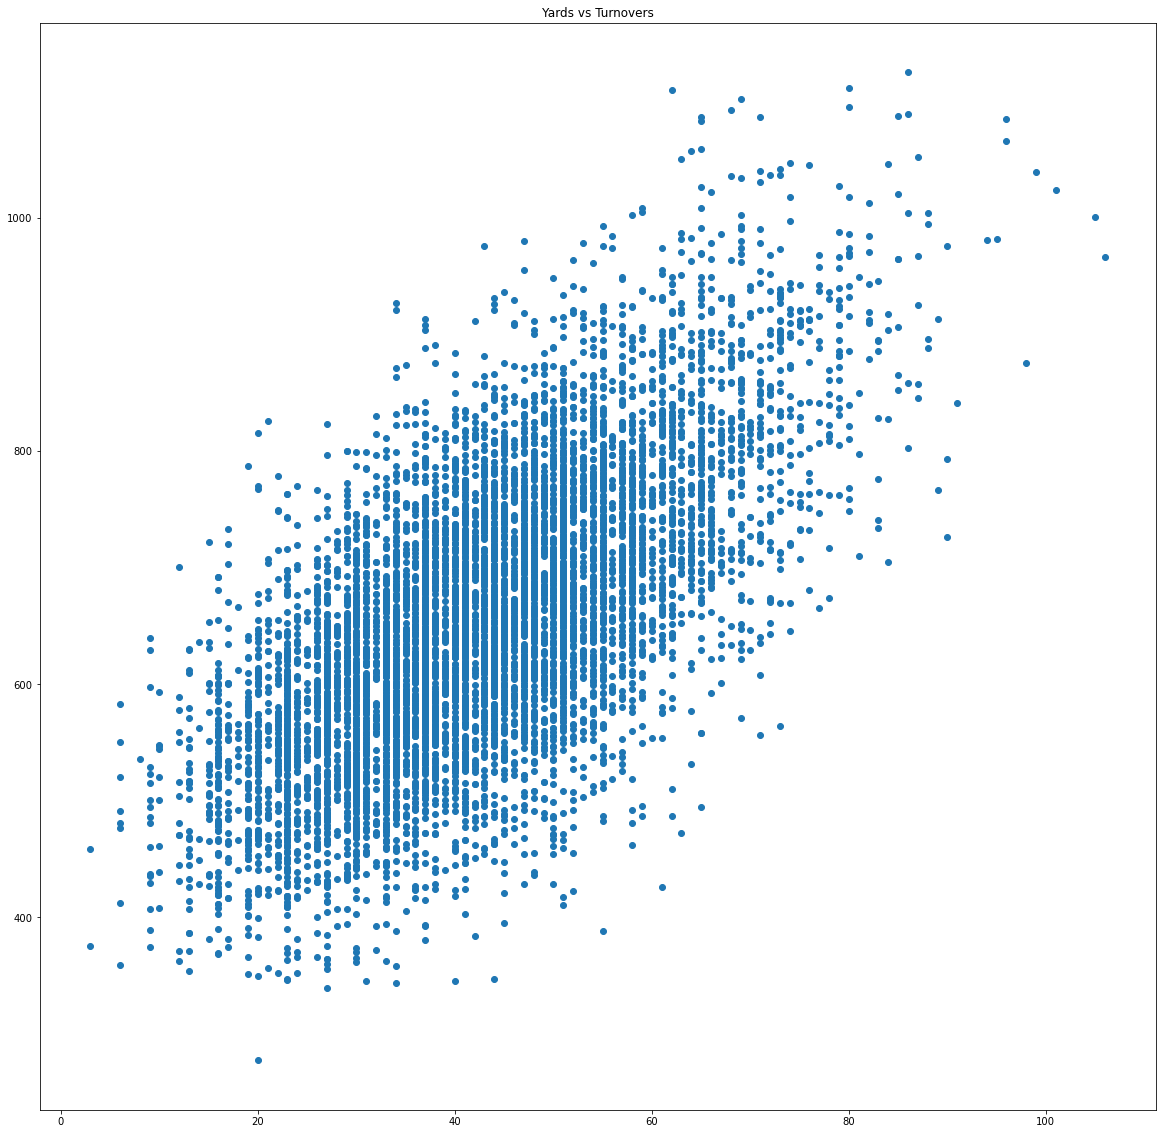

In [11]:
plt.figure(figsize = (20, 20))
plt.scatter(scores['PtsT'], scores['YdsT']);
plt.title("Yards vs Turnovers");

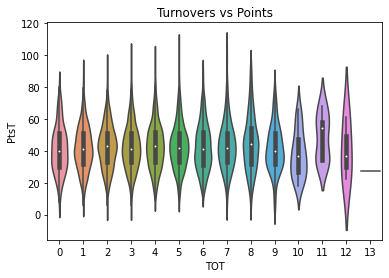

In [12]:
graph = sns.violinplot(x='TOT', y='PtsT', data=scores).set_title("Turnovers vs Points");

Here we can see that yards vs points is very promising and while turnovers is less so, there is still a small correlation that is worth further investigation.


## Analysis, Hypothesis Testing, & ML

The first step here is to test to see if there really is a correlation between points and turnovers and yards. We can figure this out by using common hypothesis testing methods such as t-tests and z-tests. If we can get low p-values then we know that there is repeatable evidence between the correlation of yards, turnovers, and points and we can reject the null hypothesis that there is no correlation. 

In [13]:
from scipy import stats
from statsmodels.formula.api import ols
from scipy.stats import ttest_ind
from statsmodels.stats import weightstats as stests
import statsmodels.api as sm
import statistics
import math 
import numpy as np 

scores_c = scores.copy()
yards_mean = np.mean(scores['YdsT']) #calculating mean of yards
pts_mean = np.mean(scores['PtsT']) #calculating mean of points
yards_std = np.std(scores['YdsT']) #calculating standard deviation of yards
pts_std = np.std(scores['PtsT']) #calculating standard deviation of points
print("Mean of yards:",yards_mean) 
print("Mean of points:",pts_mean)
print("Standard deviation of yards:",yards_std)
print("Standard deviation of points:",pts_std)
ttest,pval = ttest_ind(scores['YdsT'],scores['PtsT']) #use two-sample t-test to calculate p-value for yards vs points
print("Two sample t-test yards vs points p-value:",pval)

turnover_mean = np.mean(scores['TOT']) #mean of turnovers
turnover_std = np.std(scores['TOT']) #standard deviation of turnovers 
print("Mean of turnovers:",turnover_mean)
print("Standard deviation of turnovers:",turnover_std)
ttest,pval = ttest_ind(scores['TOT'],scores['PtsT']) #use two-sample t-test to calculate p-value for turnovers vs points
print("Two sample t-test turnovers vs points p-value:",pval)

np.random.seed(11)
scores['YdsT']= stats.norm.rvs(scale=30, loc=250, size=8524)
scores['PtsT'] = scores['YdsT'] + stats.norm.rvs(scale=5, loc=-1.25, size=8524)

ttest,pval = stats.ttest_rel(scores['YdsT'], scores['PtsT']) #paired sample t-test to get p-value for yards vs points
print("Paired sample t-test yards vs points p-value:",pval)


np.random.seed(11)
scores['TOT']= stats.norm.rvs(scale=30, loc=250, size=8524)
scores['PtsT'] = scores['TOT'] + stats.norm.rvs(scale=5, loc=-1.25, size=8524)
scores.describe() #display statistics about the scores table
ttest,pval = stats.ttest_rel(scores['TOT'], scores['PtsT']) #paired sample t-test to get p-value for turnovers vs points
print("Paired sample t-test turnovers vs points p-value:",pval)

ztest ,pval1 = stests.ztest(scores['YdsT'], x2=scores['PtsT'], value=0,alternative='two-sided') #two-sample z-test for yards vs points
print("Two sample z-test yards vs points p-value:",float(pval1))

ztest ,pval1 = stests.ztest(scores['TOT'], x2=scores['PtsT'], value=0,alternative='two-sided') #two-sample z-test for turnovers vs points
print("Two sample z-test turnovers vs points p-value:",float(pval1))

Mean of yards: 656.3222665415298
Mean of points: 42.59596433599249
Standard deviation of yards: 118.72291349746028
Standard deviation of points: 14.20191303253918
Two sample t-test yards vs points p-value: 0.0
Mean of turnovers: 3.572853120600657
Standard deviation of turnovers: 1.9538840444698065
Two sample t-test turnovers vs points p-value: 0.0
Paired sample t-test yards vs points p-value: 2.628880268377028e-106
Paired sample t-test turnovers vs points p-value: 2.628880268377028e-106
Two sample z-test yards vs points p-value: 0.00970672867165763
Two sample z-test turnovers vs points p-value: 0.00970672867165763


As we can see, all of the p-values calculated for yards vs points and turnovers vs points are very low and less than 0.05, meaning that we can reject the null hypothesis that there is no correlation between yards and points and turnovers and points. We can see that there is repeatable evidence of a correlation between yards and points and turnovers and points. 

So now that we know that there is a correlation between these factors, let’s try and create a good predicting model. First we are going to check that the association between our variables is not too high via a [pearson graph](https://www.statisticssolutions.com/pearsons-correlation-coefficient/).

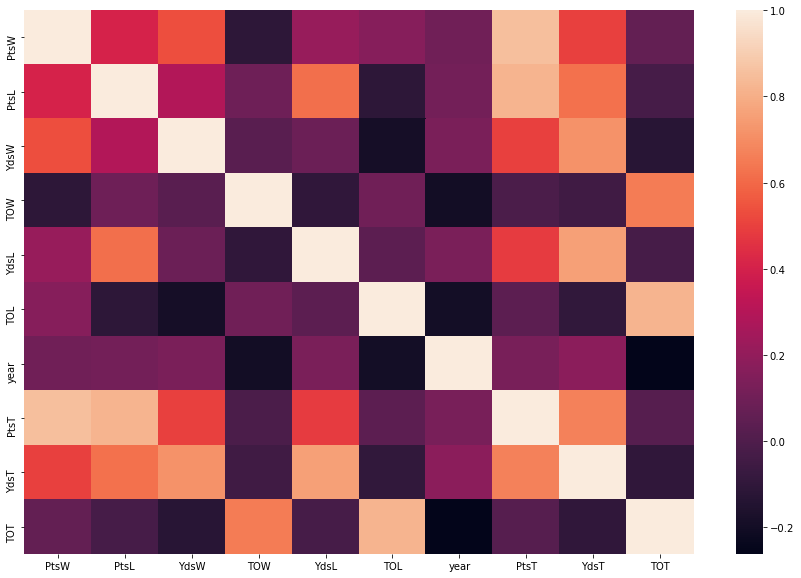

In [14]:
scores = scores_c.copy()
corr = scores.corr(method ='pearson')
plt.figure(figsize=(15, 10))
sns.heatmap(corr)
plt.show()

Here we can see there is some clear association between summed variables and their terms (as in total points is highly associated with the loser's points and the winner's points) but this could be assumed as it's almost trivial. What's important is that our two dependent variables, total yards and total turnovers are not associated with each other. 

So now that we have all of this information we can move on to building a model. The first step is to split our data into training and test data.

In [33]:
X = scores.iloc[:, 16:18].values #yards and turnovers
y = scores.iloc[:, 15].values #points

#split data train/test
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)

Next we must [normalize](https://en.wikipedia.org/wiki/Normalization_(statistics)) the data using the StandardScaler package. 

In [34]:
#normalizes
from sklearn.preprocessing import StandardScaler

sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

Now we are going to attempt to fit a [linear model](https://en.wikipedia.org/wiki/Linear_model) onto the data.

In [19]:
#Testing the linear relationships of points vs yards/turnovers.
from sklearn import linear_model
from sklearn.metrics import r2_score

#Yard Linear
X = scores.iloc[:, 16].values.reshape(-1,1) #yards 
y = scores.iloc[:, 15].values.reshape(-1,1) #points
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #splits data
regr = linear_model.LinearRegression() 
regr.fit(X_train, y_train) #applies linear regression
y_pred = regr.predict(X_test)
print("Linear Regression Yard vs Points r^2 score:", r2_score(y_test, y_pred)) #prints r2 value

#Turnover Linear 
X = scores.iloc[:, 17].values.reshape(-1,1) #turnover
y = scores.iloc[:, 15].values.reshape(-1,1) #points
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0) #splits data
regr = linear_model.LinearRegression() 
regr.fit(X_train, y_train) #applies linear regression
y_pred = regr.predict(X_test)
print("Linear Regression Turnover vs Points r^2 score:", r2_score(y_test, y_pred)) #prints r2 value

Linear Regression Yard vs Points r^2 score: 0.4373950283786946
Linear Regression Turnover vs Points r^2 score: -0.0018156565696427762


These r^2 scores are quite low. It's very clear that the linear model simply won't work. This isn't a problem as there are many other things we can try. Next, lets try a [random forest](https://en.wikipedia.org/wiki/Random_forest), a much more robust regression model. 

In [35]:
from sklearn.ensemble import RandomForestRegressor

regressor = RandomForestRegressor(n_estimators=20, random_state=0) #Random Forest regressor machine learning algorithm
regressor.fit(X_train, y_train)
y_pred = regressor.predict(X_test)
from sklearn import metrics

print('Mean Absolute Error:', metrics.mean_absolute_error(y_test, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y_test, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test, y_pred)))

Mean Absolute Error: 9.303943288849034
Mean Squared Error: 136.18611177170024
Root Mean Squared Error: 11.669880538021811


This is much better! Our model is still far from perfect but it's only around 9 points off the final total score of a game on average. Considering how many aspects go into  determining the final score of a game, it's not bad to be able to get this close using only yards and turnovers. Let's take a look at some residual graphs of our model to see how it looks.

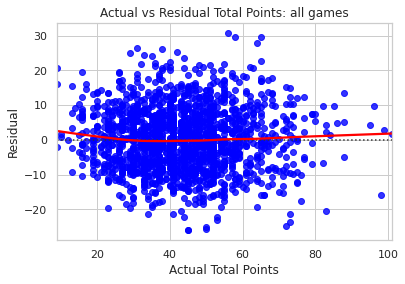

In [42]:
#Graph of residuals, all
sns.set_theme(style="whitegrid")
plot = sns.residplot(x = y_test, y = y_pred, lowess = True, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, robust = True) #sets points to blue, line to red
plot.set(xlabel='Actual Total Points', ylabel = 'Residual', title = 'Actual vs Residual Total Points: all games')
plot;

This is a bit of a mess, lets take a look at just a smaller section of data to make a cleaner graph:

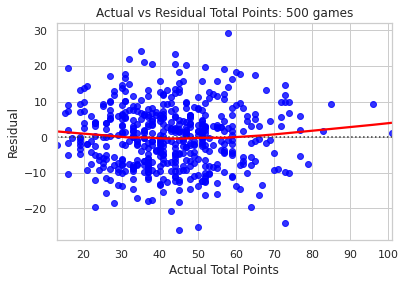

In [44]:
#Graph of residuals, small sample
sns.set_theme(style="whitegrid")
plot = sns.residplot(x = y_test[:500], y = y_pred[:500], lowess = True, scatter_kws={"color": "blue"}, line_kws={"color": "red"}, robust = True) #sets points to blue, line to red
plot.set(xlabel='Actual Total Points', ylabel = 'Residual', title = 'Actual vs Residual Total Points: 500 games')
plot;

## Conclusion

So in the end our model was decent, but far from perfect. After collecting, tidying, visualizing, and applying machine learning to our data, we got a model that was able to predict a score that was with about 9 points of the actual total score. This tells us a couple of things. The first is that there is more that needs to be done to make this fully usable. To get a good prediction we could try some different things including but not limited to: adding more data about each observation such as weather, a team’s past performance, or even who was coaching at the time. The more data we have, the better we can fit our data (although we do have to watch out for [overfitting](https://www.investopedia.com/terms/o/overfitting.asp)). We can also wait for more data to come out. As time goes on, more games will be played and this too might improve our model. The other thing we can take away from this tutorial is that there almost certainly is a better way than what much of the industry is doing today. While we didn’t fully hit the mark, we got closer, there is almost certainly some model that can be made that predicts score more accurately than the subjective opinions of some “expert” in sports gambling. A movement towards more data-driven predictions is coming and machine learning like this is what drives it.
